# Simulating the Conservative and Speculative portfolios with equal weighting and market weighting methods to test if Conservative Formula Investing generates Surplus Returns in the Indian Equity Markets

# Import packages and Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#Load data
market_cap_mapping_path = 'clean data/quarterly market cap mapping.xlsx'
momentum_path = 'clean data/quarterly momentum.xlsx'
net_payout_yield_path = 'clean data/quarterly net payout yield.xlsx'
price_path = 'clean data/quarterly price.xlsx'
volatility_path = 'clean data/quarterly volatility.xlsx'

mcap_map = pd.read_excel(market_cap_mapping_path)
momentum = pd.read_excel(momentum_path)
npy = pd.read_excel(net_payout_yield_path)
price = pd.read_excel(price_path)
volatility = pd.read_excel(volatility_path)
outstanding_shares = pd.read_excel('clean data/quarterly outstanding shares.xlsx')

price.set_index('quarter', inplace=True)
momentum.set_index('quarter', inplace=True)
npy.set_index('quarter', inplace=True)
volatility.set_index('quarter', inplace=True)
outstanding_shares.set_index('quarter',inplace = True)

mcap_map.set_index('quarter',inplace = True)
mcapmap = mcap_map
mcapmap = pd.DataFrame(mcap_map.apply(lambda row: row.dropna().tolist(), axis=1))
mcapmap.columns = mcapmap.columns.map(str)
mcapmap.rename(columns={'0': 'top1100'}, inplace=True)


# Define Functions needed to Simulate the Portfolios

In [23]:
# Function to calculate returns for an equal weight portfolio
def calculate_ew_returns(portfolio, prices_start, prices_end):
    start_prices = prices_start[portfolio]
    end_prices = prices_end[portfolio]
    returns = (end_prices / start_prices).mean() - 1
    return returns

# Function to calculate returns for a market weight portfolio
def calculate_mw_returns(portfolio, prices_start, prices_end, outstanding_shares):
    # Calculate market caps for the start of the quarter
    start_prices = prices_start[portfolio]
    shares_start = outstanding_shares.loc[prices_start.name, portfolio]
    market_caps_start = start_prices * shares_start

    # Calculate weights
    total_market_cap = market_caps_start.sum()
    weights = market_caps_start / total_market_cap

    # Calculate portfolio return using weighted average
    end_prices = prices_end[portfolio]
    returns = ((end_prices / start_prices - 1) * weights).sum()
    return returns


# function to rank stocks to construct the conservative portfolio 
def rank_stocks_con(group):
    momentum_data = momentum.loc[quarter, group].dropna()
    npy_data = npy.loc[quarter, group].dropna()
    common_stocks = set(momentum_data.index).intersection(npy_data.index)
    momentum_rank = momentum_data.loc[common_stocks].rank(ascending=False)
    npy_rank = npy_data.loc[common_stocks].rank(ascending=False)
    aggregate_rank = (momentum_rank + npy_rank) / 2
    aggregate_rank_sorted = aggregate_rank.sort_values()
    return aggregate_rank_sorted.head(100).index.tolist()


# function to rank stocks to construct the speculative portfolio 
def rank_stocks_spec(group):
    momentum_data = momentum.loc[quarter, group].dropna()
    npy_data = npy.loc[quarter, group].dropna()
    common_stocks = set(momentum_data.index).intersection(npy_data.index)
    momentum_rank = momentum_data.loc[common_stocks].rank(ascending=True)
    npy_rank = npy_data.loc[common_stocks].rank(ascending=True)
    aggregate_rank = (momentum_rank + npy_rank) / 2
    aggregate_rank_sorted = aggregate_rank.sort_values()
    return aggregate_rank_sorted.head(100).index.tolist()



# Simulate the Equally Weighted Conservative and Speculative Portfolios 

Final conservative portfolio balance: ₹1,077,499,425.57
Final speculative portfolio balance: ₹35,530,731.83


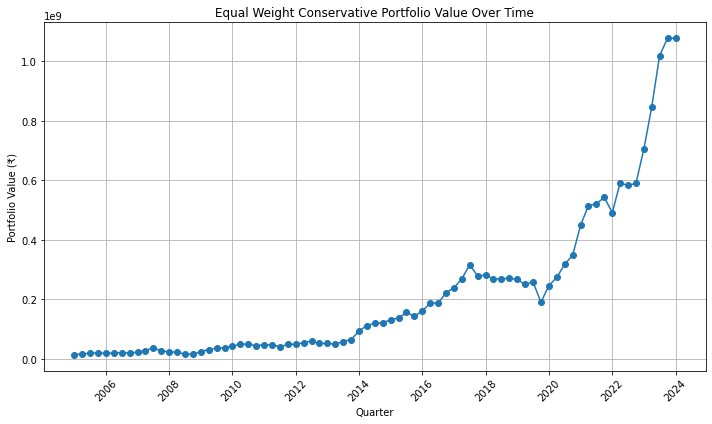

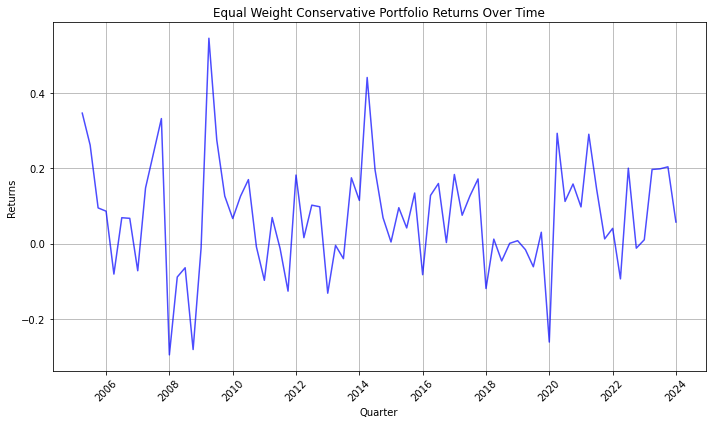

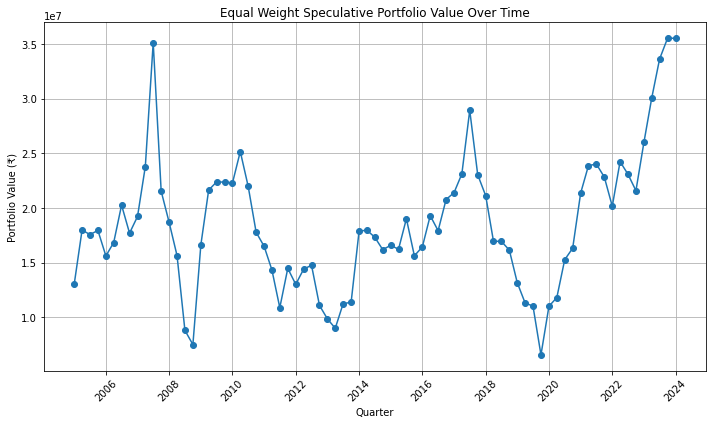

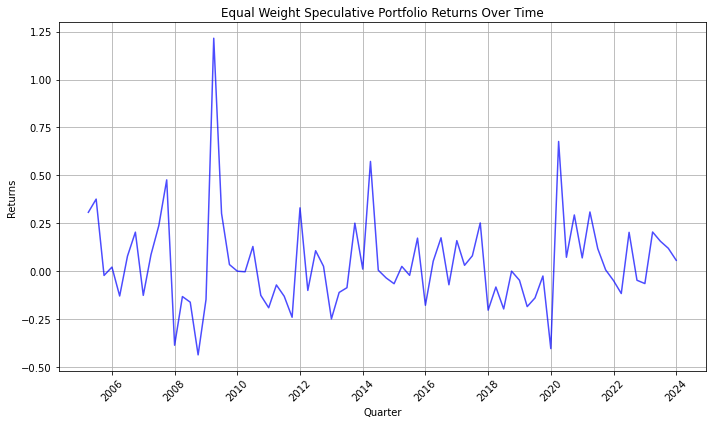

In [24]:
initial_cash = 1e7  # ₹1 crore
conservative_cash = initial_cash
speculative_cash = initial_cash

# Initialize portfolio log
portfolio_log_con = pd.DataFrame(columns=['portfolio'])
portfolio_log_spec = pd.DataFrame(columns=['portfolio'])

portfolio_values_con = []  
portfolio_returns_con = [] 

portfolio_values_spec = []  
portfolio_returns_spec = []  


for quarter in mcapmap.index:
    # Get stock list for the quarter
    stocks = mcapmap.loc[quarter].dropna().values[0]

    # Filter stocks with available volatility data
    stocks_with_volatility = [s for s in stocks if not pd.isna(volatility.loc[quarter, s])]
    vol_data = volatility.loc[quarter, stocks_with_volatility].dropna()

    # Sort stocks by volatility
    vol_sorted_stocks = vol_data.sort_values().index.tolist()

    # Select lower volatility group
    mid = len(vol_sorted_stocks) // 2
    lower_vol_group = vol_sorted_stocks[:mid]
    higher_vol_group = vol_sorted_stocks[mid:]   
    
    conservative_portfolio = rank_stocks_con(lower_vol_group)
    speculative_portfolio = rank_stocks_spec(higher_vol_group)
    portfolio_log_con.loc[quarter] = [conservative_portfolio]
    portfolio_log_spec.loc[quarter] = [speculative_portfolio]

        
    # Calculate returns for the conservative portfolio
    if quarter != mcapmap.index[-1]:  
        next_quarter = mcapmap.index[mcapmap.index.get_loc(quarter) + 1]

        if len(conservative_portfolio) > 0:
            conservative_returns = calculate_ew_returns(
                conservative_portfolio, price.loc[quarter], price.loc[next_quarter]
            )
            conservative_cash *= (1 + conservative_returns)
            portfolio_returns_con.append(conservative_returns)
        else:
            portfolio_returns_spec.append(0)

    portfolio_values_con.append(conservative_cash)
    
    
    # Calculate returns for the speculative portfolio
    if quarter != mcapmap.index[-1]:  
        next_quarter = mcapmap.index[mcapmap.index.get_loc(quarter) + 1]

        if len(speculative_portfolio) > 0:
            speculative_returns = calculate_ew_returns(
                speculative_portfolio, price.loc[quarter], price.loc[next_quarter]
            )
            speculative_cash *= (1 + speculative_returns)
            portfolio_returns_spec.append(speculative_returns)
        else:
            portfolio_returns_spec.append(0)

    # Log portfolio value
    portfolio_values_spec.append(speculative_cash)
    

# Print final cash balance
print(f"Final conservative portfolio balance: ₹{conservative_cash:,.2f}")
print(f"Final speculative portfolio balance: ₹{speculative_cash:,.2f}")
con_ew_cash = conservative_cash
spec_ew_cash = speculative_cash

# Create a DataFrame for portfolio values and returns
dates = list(mcapmap.index)[:len(portfolio_values_con)]
con_ew_performance = pd.DataFrame({
    'Date': dates,
    'Portfolio Value': portfolio_values_con,
    'Returns': [0] + portfolio_returns_con 
})
dates = list(mcapmap.index)[:len(portfolio_values_spec)]
spec_ew_performance = pd.DataFrame({
    'Date': dates,
    'Portfolio Value': portfolio_values_spec,
    'Returns': [0] + portfolio_returns_spec  
})


# Plot portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(con_ew_performance['Date'], con_ew_performance['Portfolio Value'], marker='o')
plt.title('Equal Weight Conservative Portfolio Value Over Time')
plt.xlabel('Quarter')
plt.ylabel('Portfolio Value (₹)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot portfolio returns over time
plt.figure(figsize=(10, 6))
plt.plot(con_ew_performance['Date'][1:], con_ew_performance['Returns'][1:], color='blue', alpha=0.7)
plt.title('Equal Weight Conservative Portfolio Returns Over Time')
plt.xlabel('Quarter')
plt.ylabel('Returns')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(spec_ew_performance['Date'], spec_ew_performance['Portfolio Value'], marker='o')
plt.title('Equal Weight Speculative Portfolio Value Over Time')
plt.xlabel('Quarter')
plt.ylabel('Portfolio Value (₹)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot portfolio returns over time
plt.figure(figsize=(10, 6))
plt.plot(spec_ew_performance['Date'][1:], spec_ew_performance['Returns'][1:], color='blue', alpha=0.7)
plt.title('Equal Weight Speculative Portfolio Returns Over Time')
plt.xlabel('Quarter')
plt.ylabel('Returns')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Simulate The Market Weighted Conservative and Speculative Portfolios 

Final conservative portfolio balance: ₹296,541,654.58
Final speculative portfolio balance: ₹14,722,512.97


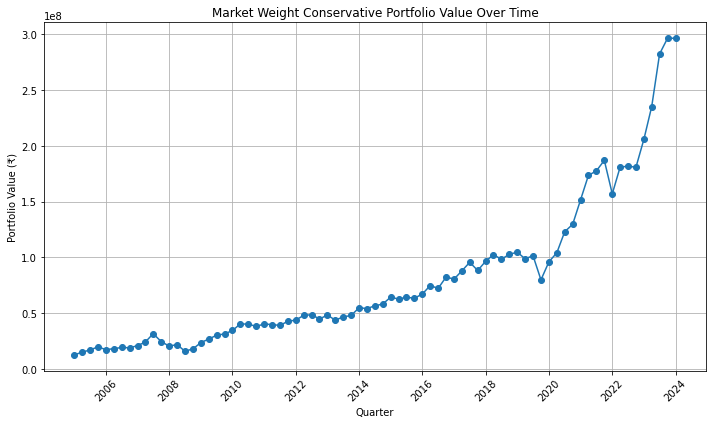

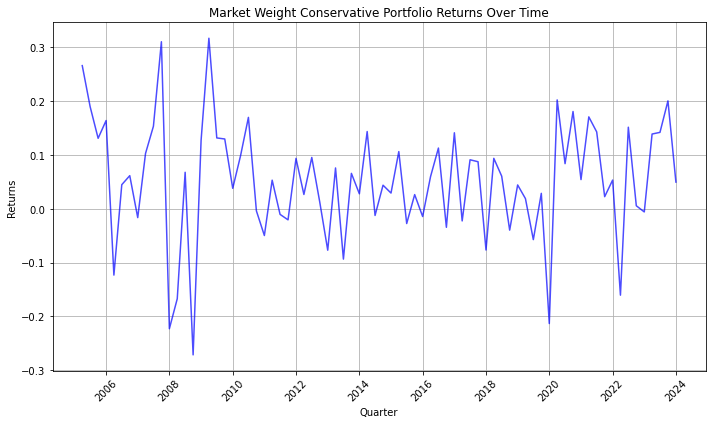

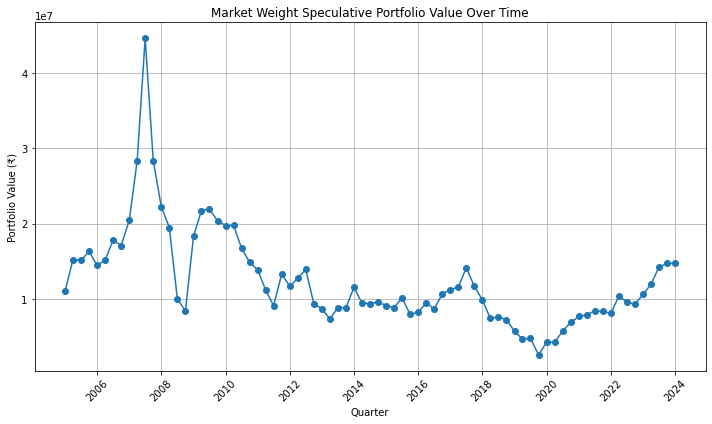

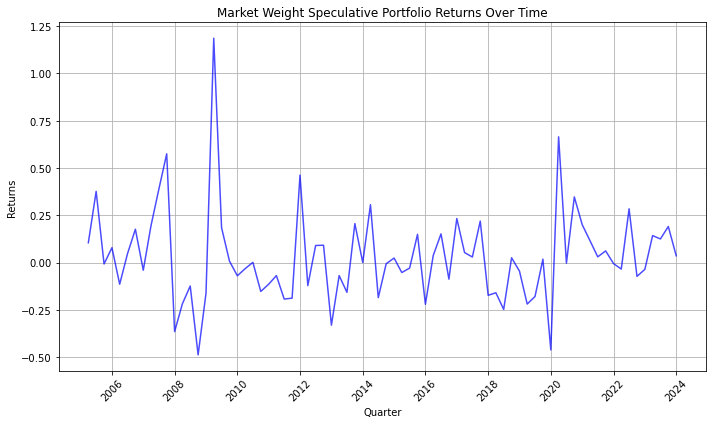

In [9]:
initial_cash = 1e7  # ₹1 crore
conservative_cash = initial_cash
speculative_cash = initial_cash

# Initialize portfolio log
portfolio_log_con = pd.DataFrame(columns=['portfolio'])
portfolio_log_spec = pd.DataFrame(columns=['portfolio'])
portfolio_values_con = []  
portfolio_returns_con = [] 
portfolio_values_spec = []  
portfolio_returns_spec = [] 


for quarter in mcapmap.index:
    # Get stock list for the quarter
    stocks = mcapmap.loc[quarter].dropna().values[0]

    # Filter stocks with available volatility
    stocks_with_volatility = [s for s in stocks if not pd.isna(volatility.loc[quarter, s])]
    vol_data = volatility.loc[quarter, stocks_with_volatility].dropna()

    # Sort stocks by volatility
    vol_sorted_stocks = vol_data.sort_values().index.tolist()

    
    mid = len(vol_sorted_stocks) // 2
    lower_vol_group = vol_sorted_stocks[:mid]
    higher_vol_group = vol_sorted_stocks[mid:]   
    
    conservative_portfolio = rank_stocks_con(lower_vol_group)
    speculative_portfolio = rank_stocks_spec(higher_vol_group)
    portfolio_log_con.loc[quarter] = [conservative_portfolio]
    portfolio_log_spec.loc[quarter] = [speculative_portfolio]

        
    # Calculate returns for the conservative portfolio
    if quarter != mcapmap.index[-1]: 
        next_quarter = mcapmap.index[mcapmap.index.get_loc(quarter) + 1]

        if len(conservative_portfolio) > 0:
            conservative_returns = calculate_mw_returns(
                conservative_portfolio, price.loc[quarter], price.loc[next_quarter], outstanding_shares
            )
            conservative_cash *= (1 + conservative_returns)
            portfolio_returns_con.append(conservative_returns)
        else:
            portfolio_returns_spec.append(0)

    portfolio_values_con.append(conservative_cash)
    
    
    # Calculate returns for the speculative portfolio
    if quarter != mcapmap.index[-1]: 
        next_quarter = mcapmap.index[mcapmap.index.get_loc(quarter) + 1]

        if len(speculative_portfolio) > 0:
            speculative_returns = calculate_mw_returns(
                speculative_portfolio, price.loc[quarter], price.loc[next_quarter], outstanding_shares
            )
            speculative_cash *= (1 + speculative_returns)
            portfolio_returns_spec.append(speculative_returns)
        else:
            portfolio_returns_spec.append(0)

    portfolio_values_spec.append(speculative_cash)
    

# Print final cash balance
print(f"Final conservative portfolio balance: ₹{conservative_cash:,.2f}")
print(f"Final speculative portfolio balance: ₹{speculative_cash:,.2f}")
con_mw_cash = conservative_cash
spec_mw_cash = speculative_cash


# Create a DataFrame for portfolio values and returns
dates = list(mcapmap.index)[:len(portfolio_values_con)]
con_mw_performance = pd.DataFrame({
    'Date': dates,
    'Portfolio Value': portfolio_values_con,
    'Returns': [0] + portfolio_returns_con 
})
dates = list(mcapmap.index)[:len(portfolio_values_spec)]
spec_mw_performance = pd.DataFrame({
    'Date': dates,
    'Portfolio Value': portfolio_values_spec,
    'Returns': [0] + portfolio_returns_spec 
})


# Plot portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(con_mw_performance['Date'], con_mw_performance['Portfolio Value'], marker='o')
plt.title('Market Weight Conservative Portfolio Value Over Time')
plt.xlabel('Quarter')
plt.ylabel('Portfolio Value (₹)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot portfolio returns over time
plt.figure(figsize=(10, 6))
plt.plot(con_mw_performance['Date'][1:], con_mw_performance['Returns'][1:], color='blue', alpha=0.7)
plt.title('Market Weight Conservative Portfolio Returns Over Time')
plt.xlabel('Quarter')
plt.ylabel('Returns')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(spec_mw_performance['Date'], spec_mw_performance['Portfolio Value'], marker='o')
plt.title('Market Weight Speculative Portfolio Value Over Time')
plt.xlabel('Quarter')
plt.ylabel('Portfolio Value (₹)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot portfolio returns over time
plt.figure(figsize=(10, 6))
plt.plot(spec_mw_performance['Date'][1:], spec_mw_performance['Returns'][1:], color='blue', alpha=0.7)
plt.title('Market Weight Speculative Portfolio Returns Over Time')
plt.xlabel('Quarter')
plt.ylabel('Returns')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Simulate the BSE 100 Portfolio for Benchmarking Purposes

Final BSE 100 portfolio balance: ₹115,346,722.92


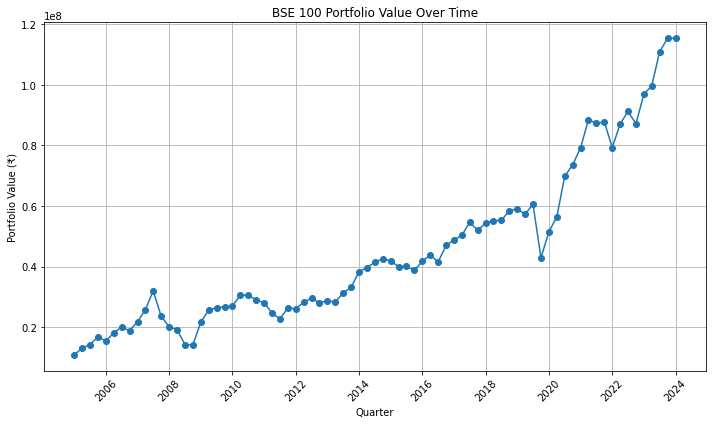

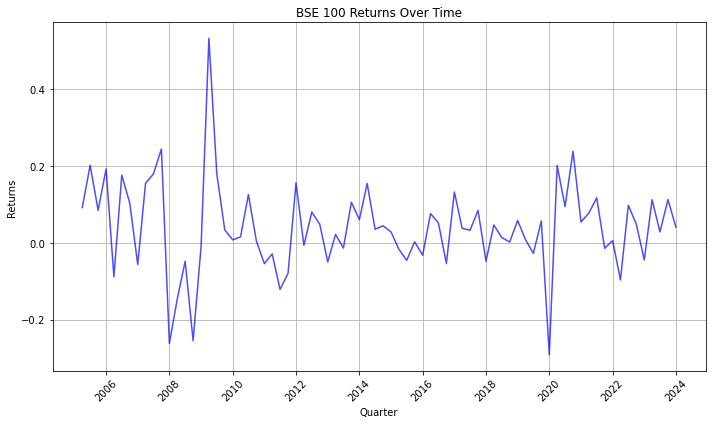

In [10]:
bse = pd.read_excel('clean data/quarterly bse100.xlsx')
bse.set_index('quarter', inplace = True)
def calculate_bse_returns(start, end):
    returns = end['Close']/start['Close'] - 1
    return returns

portfolio_values_bse = [] 
portfolio_returns_bse = []  
bse_cash = 1e7

for quarter in bse.index:
    if quarter != bse.index[-1]: 
        next_quarter = bse.index[bse.index.get_loc(quarter) + 1]
        bse_returns = calculate_bse_returns(bse.loc[quarter], bse.loc[next_quarter])
        bse_cash *= (1 + bse_returns)
        portfolio_returns_bse.append(bse_returns)

    portfolio_values_bse.append(bse_cash)

dates = list(bse.index)[:len(portfolio_values_bse)]
bse_performance = pd.DataFrame({
    'Date': dates,
    'Portfolio Value': portfolio_values_bse,
    'Returns': [0] + portfolio_returns_bse  
})

print(f"Final BSE 100 portfolio balance: ₹{bse_cash:,.2f}")
# Plot portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(bse_performance['Date'], bse_performance['Portfolio Value'], marker='o')
plt.title('BSE 100 Portfolio Value Over Time')
plt.xlabel('Quarter')
plt.ylabel('Portfolio Value (₹)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot portfolio returns over time
plt.figure(figsize=(10, 6))
plt.plot(bse_performance['Date'][1:], bse_performance['Returns'][1:], color='blue', alpha=0.7)
plt.title('BSE 100 Returns Over Time')
plt.xlabel('Quarter')
plt.ylabel('Returns')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Comparative Analysis: Measuring and Visualizing the Performance of the Conservative Portfolio against the Speculative Portfolio (with both weighting methods) and the BSE 100

## 1. Portfolio Growth over Time

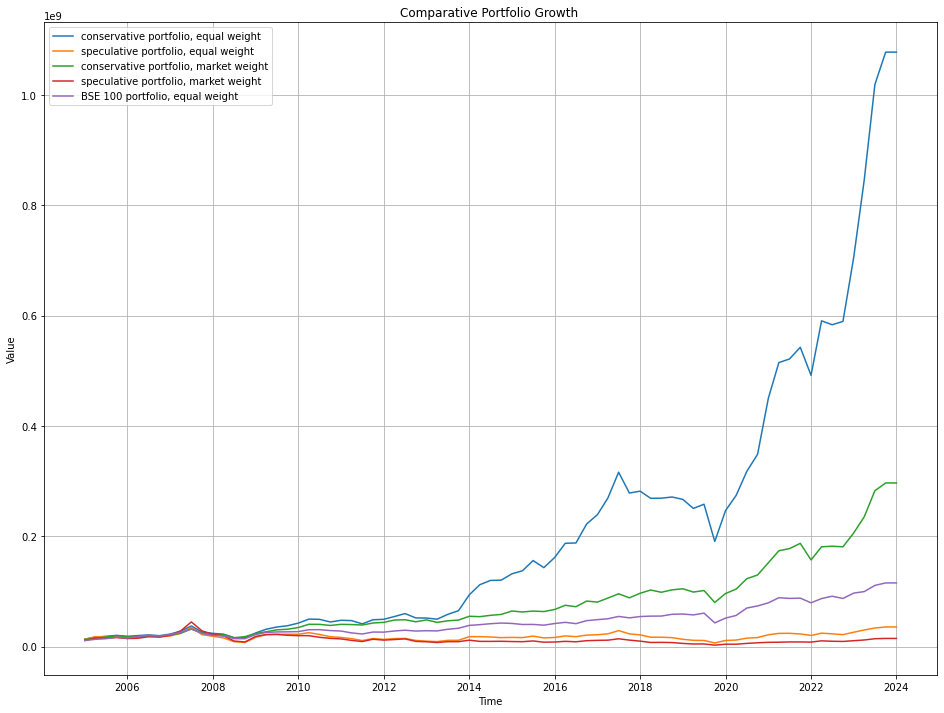

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))

plt.plot(con_ew_performance['Date'], con_ew_performance['Portfolio Value'], label='conservative portfolio, equal weight')
plt.plot(spec_ew_performance['Date'], spec_ew_performance['Portfolio Value'], label='speculative portfolio, equal weight')
plt.plot(con_mw_performance['Date'], con_mw_performance['Portfolio Value'], label='conservative portfolio, market weight')
plt.plot(spec_mw_performance['Date'], spec_mw_performance['Portfolio Value'], label='speculative portfolio, market weight')
plt.plot(bse_performance['Date'], bse_performance['Portfolio Value'], label='BSE 100 portfolio, equal weight')

plt.title('Comparative Portfolio Growth ')
plt.xlabel('Time')
plt.ylabel('Value')

plt.legend()
plt.grid()
plt.show()

## 2. Quarterly Returns 

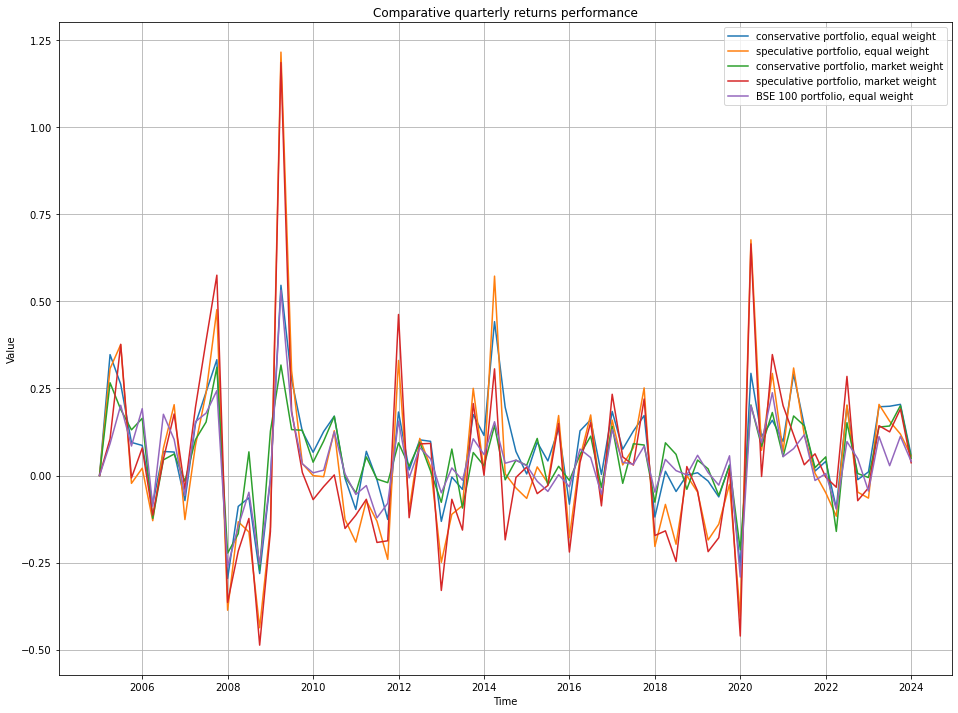

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))

plt.plot(con_ew_performance['Date'], con_ew_performance['Returns'], label='conservative portfolio, equal weight')
plt.plot(spec_ew_performance['Date'], spec_ew_performance['Returns'], label='speculative portfolio, equal weight')
plt.plot(con_mw_performance['Date'], con_mw_performance['Returns'], label='conservative portfolio, market weight')
plt.plot(spec_mw_performance['Date'], spec_mw_performance['Returns'], label='speculative portfolio, market weight')
plt.plot(bse_performance['Date'], bse_performance['Returns'], label='BSE 100 portfolio, equal weight')

plt.title('Comparative quarterly returns performance')
plt.xlabel('Time')
plt.ylabel('Value')

plt.legend()

plt.grid()

plt.show()

## 3. Rolling 3-Year Sharpe Ratio

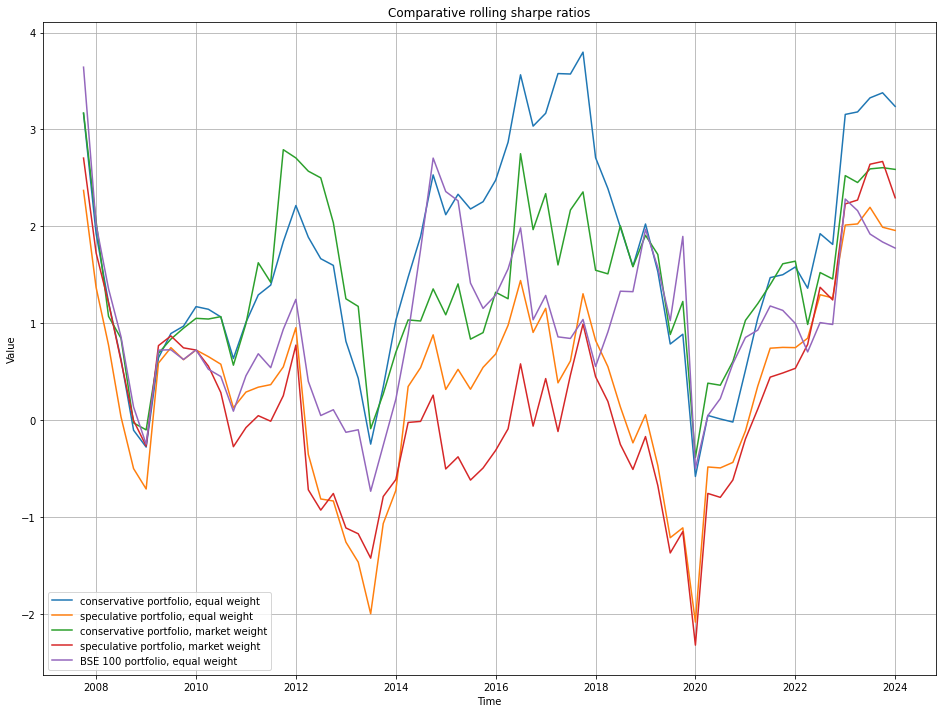

In [20]:
def compute_rolling_sharpe(portfolio_performance):
    df = portfolio_performance
    rolling_window = 12
    risk_free_rate = 0.04  # assumed arbitrarily

    rolling_mean = df['Returns'].rolling(window=rolling_window).mean()
    rolling_std = df['Returns'].rolling(window=rolling_window).std()

    sharpe_ratio = (rolling_mean*4 - risk_free_rate) / rolling_std

    df['Sharpe'] = sharpe_ratio
    return df

con_ew_performance = compute_rolling_sharpe(con_ew_performance)
con_mw_performance = compute_rolling_sharpe(con_mw_performance)
spec_ew_performance = compute_rolling_sharpe(spec_ew_performance)
spec_mw_performance = compute_rolling_sharpe(spec_mw_performance)
bse_performance = compute_rolling_sharpe(bse_performance)

plt.figure(figsize=(16, 12))

plt.plot(con_ew_performance['Date'], con_ew_performance['Sharpe'], label='conservative portfolio, equal weight')
plt.plot(spec_ew_performance['Date'], spec_ew_performance['Sharpe'], label='speculative portfolio, equal weight')
plt.plot(con_mw_performance['Date'], con_mw_performance['Sharpe'], label='conservative portfolio, market weight')
plt.plot(spec_mw_performance['Date'], spec_mw_performance['Sharpe'], label='speculative portfolio, market weight')
plt.plot(bse_performance['Date'], bse_performance['Sharpe'], label='BSE 100 portfolio, equal weight')

plt.title('Comparative rolling sharpe ratios')
plt.xlabel('Time')
plt.ylabel('Value')

plt.legend()

plt.grid()

plt.show()

## 4. Risk-Return Scatter Plot

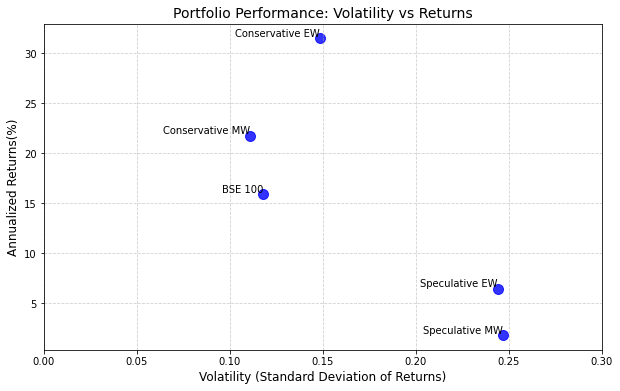

In [19]:
def compute_cagr(portfolio_performance):
    i = portfolio_performance['Portfolio Value'].iloc[0]
    f = portfolio_performance['Portfolio Value'].iloc[-1]
    cagr = (((f/i)**(1/16))-1) * 100
    return cagr

con_ew_cagr = compute_cagr(con_ew_performance)
spec_ew_cagr = compute_cagr(spec_ew_performance)
con_mw_cagr = compute_cagr(con_mw_performance)
spec_mw_cagr = compute_cagr(spec_mw_performance)
bse_cagr = compute_cagr(bse_performance)


def compute_vol(portfolio_performance):
    vol = portfolio_performance['Returns'].std()
    return vol
 
con_ew_vol = compute_vol(con_ew_performance)
spec_ew_vol = compute_vol(spec_ew_performance)
con_mw_vol = compute_vol(con_mw_performance)
spec_mw_vol = compute_vol(spec_mw_performance)
bse_vol = compute_vol(bse_performance)

portfolio_names = [
    "Conservative EW", 
    "Speculative EW", 
    "Conservative MW", 
    "Speculative MW", 
    "BSE 100"
]
volatilities = [con_ew_vol, spec_ew_vol, con_mw_vol, spec_mw_vol, bse_vol]
cagrs = [con_ew_cagr, spec_ew_cagr, con_mw_cagr, spec_mw_cagr, bse_cagr]

plt.figure(figsize=(10, 6))
plt.scatter(volatilities, cagrs, color="blue", s=100, alpha=0.8)

for i, name in enumerate(portfolio_names):
    plt.text(volatilities[i], cagrs[i], name, fontsize=10, ha='right', va='bottom')

plt.title("Portfolio Performance: Volatility vs Returns", fontsize=14)
plt.xlabel("Volatility (Standard Deviation of Returns)", fontsize=12)
plt.ylabel("Annualized Returns(%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0,0.3)
plt.show()